In [37]:
# Helper methods for pre-processing input
# Articles used https://medium.com/@jonathan_hui/gan-dcgan-deep-convolutional-generative-adversarial-networks-df855c438f

import numpy as np
import pandas as ps
import os
import cv2

In [38]:
path = "C:\\Users\\Cordu\\cats\\"
images = np.empty([len(os.listdir(path)),64,64,3])
i = 0

for file in os.listdir(path):
    image = cv2.imread(path + file)
    im_array = np.asarray(image) / 255
    images[i] = im_array
    i = i + 1

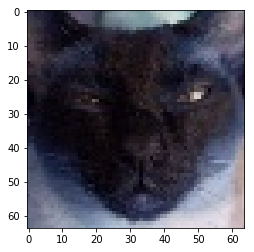

In [39]:
import matplotlib.pyplot as plt

im = images[540]
plt.imshow(im)

In [40]:
import keras
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input, Activation
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Conv2DTranspose, GaussianNoise, InputLayer

In [41]:
def create_generator():
    epsilon = 0.00001 # Small float added to variance to avoid dividing by zero in the BatchNorm layers.
    noise_shape = (100,)

    model = Sequential()

    model.add(Dense(4*4*512, activation='linear', input_shape=(100,)))
    model.add(Reshape((4, 4, 512)))

    model.add(Conv2DTranspose(256, kernel_size=[5,5], strides=[2,2], padding="same",
                              kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
    model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(256, kernel_size=[5,5], strides=[2,2], padding="same",
                              kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
    model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(128, kernel_size=[5,5], strides=[2,2], padding="same",
                              kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
    model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(64, kernel_size=[5,5], strides=[2,2], padding="same",
                              kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
    model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(3, kernel_size=[5,5], strides=[1,1], padding="same",
                              kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
    # Standard activation for the generator of a GAN
    model.add(Activation("tanh"))

    model.summary()

    noise = Input(shape=(100,))
    img = model(noise)

    return Model(noise, img)

generator = create_generator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_3 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_9 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
activation_11 (Activation)   (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 16, 16, 256)       1638656   
_________________________________________________________________
batch_normalization_10 (Batc (None, 16, 16, 256)       1024      
__________

In [42]:
def build_discriminator():

    model = Sequential()

    model = Sequential()
    model.add(InputLayer(input_shape=(64,64,3)))
    model.add(GaussianNoise(0.2))
    model.add(Conv2D(32, (3, 3), strides=[2,2],padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(.3))
    model.add(Conv2D(64, (3, 3),strides=[2,2], kernel_initializer='he_uniform', padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(.3))
    model.add(Conv2D(128, (3, 3),strides=[2,2], kernel_initializer='he_uniform', padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(.3))
    model.add(Conv2D(256, (3, 3),strides=[2,2], kernel_initializer='he_uniform', padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(.3))
    model.add(Conv2D(512, (3, 3),strides=[2,2], kernel_initializer='he_uniform', padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(.3))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
        
    model.summary()
        
    img = Input(shape=(64,64,3))
    validity = model(img)

    return Model(img, validity)

discriminator = build_discriminator()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_2 (GaussianNo (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 16, 16, 64)        0         
__________

In [43]:
def get_gan():
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.summary()
    
    return model

gan = get_gan()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_6 (Model)              (None, 64, 64, 3)         6774915   
_________________________________________________________________
model_7 (Model)              (None, 1)                 1570625   
Total params: 8,345,540
Trainable params: 8,344,132
Non-trainable params: 1,408
_________________________________________________________________


In [44]:
optimizer = Adam(0.0002,0.5)
discriminator.compile(loss='binary_crossentropy', 
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
discriminator.trainable = False
generator.compile(loss='binary_crossentropy', optimizer=optimizer)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

In [32]:
def save_images(epoch):
        noise = np.random.normal(0, 1, [100, 100])
        gen_imgs = generator.predict(noise)
        #gen_imgs = 0.5 * gen_imgs + 0.5
        
        fig, axs = plt.subplots(5,5, figsize = (15,15))

        for i in range(5):
            for j in range(5):
                axs[i,j].imshow((gen_imgs[5*i+j]))
                axs[i,j].axis('off')
        fig.savefig("catsGeneratedv2/Faces_%d.png" % epoch)
        plt.show()

In [49]:
from keras.models import load_model

discriminator = load_model('cats_discriminatorV2.h5')
generator = load_model('cats_generatorV2.h5')

[0.32539823 1.        ]
1.192093321833454e-07


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

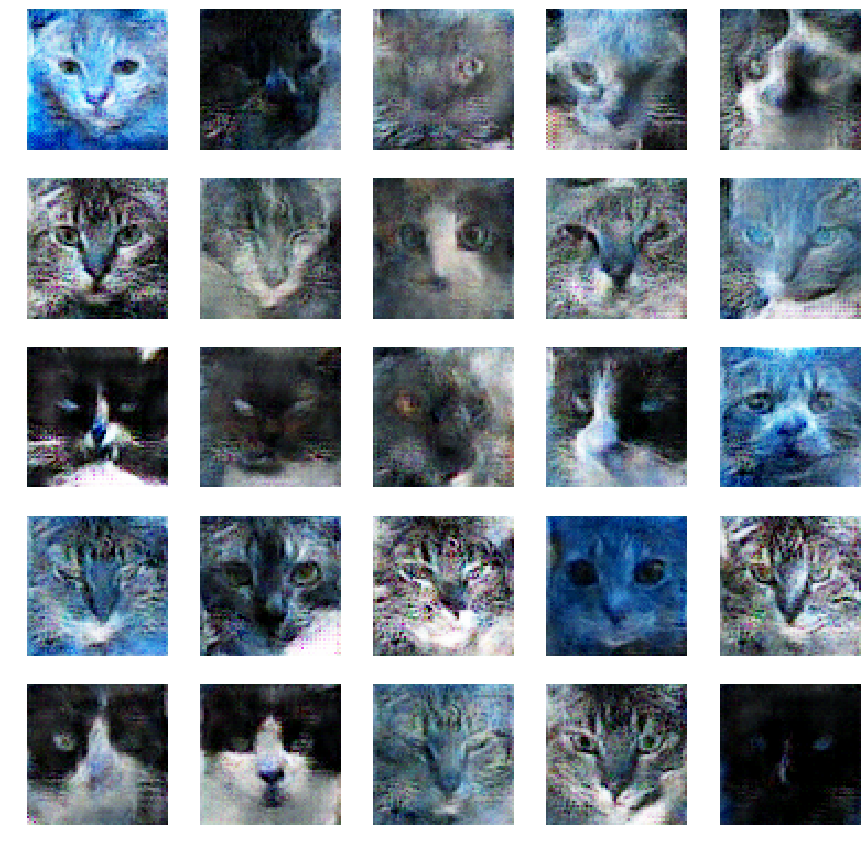

[0.6507278 2.       ]
1.20163938532869e-05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

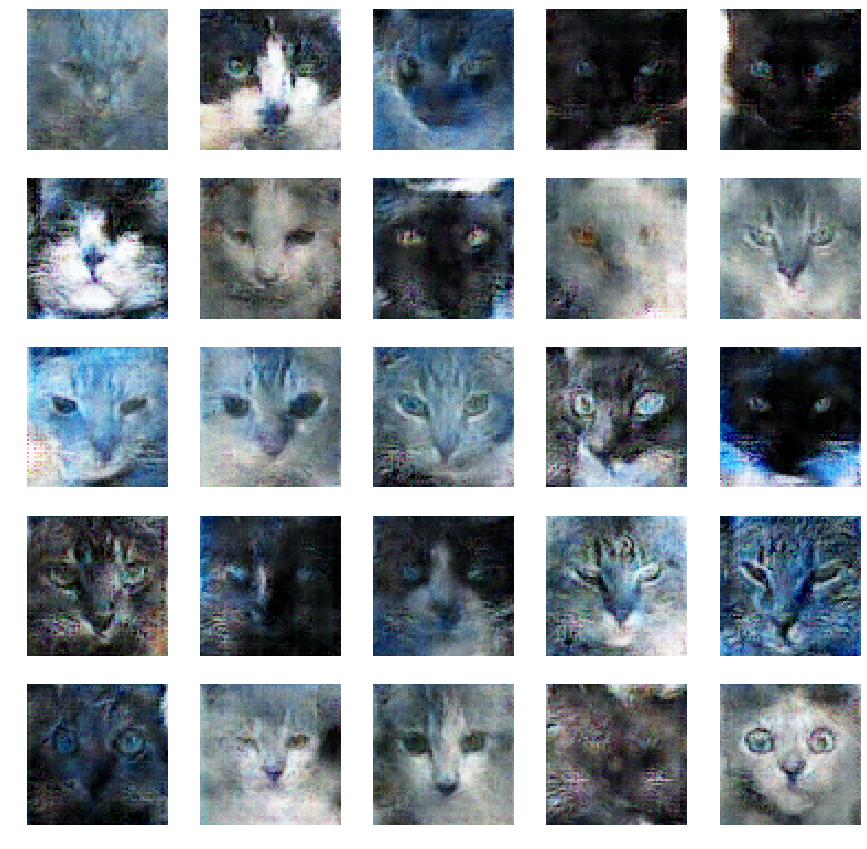

[0.65150028 2.        ]
1.200288971858754e-05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

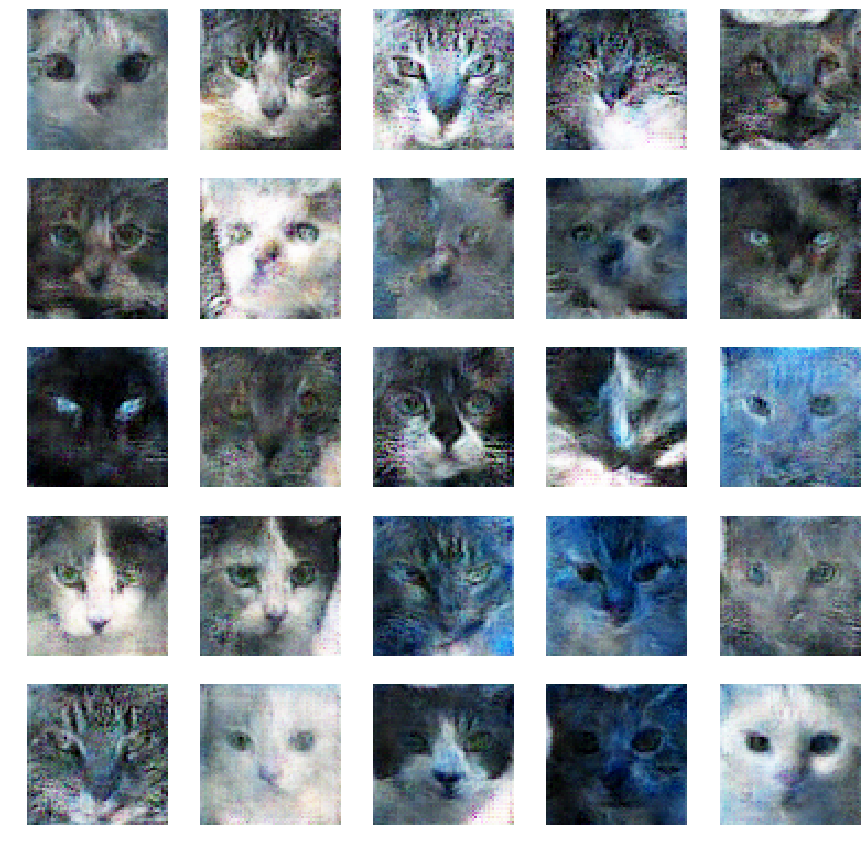

[0.65052792 2.        ]
1.2037348668059167e-05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

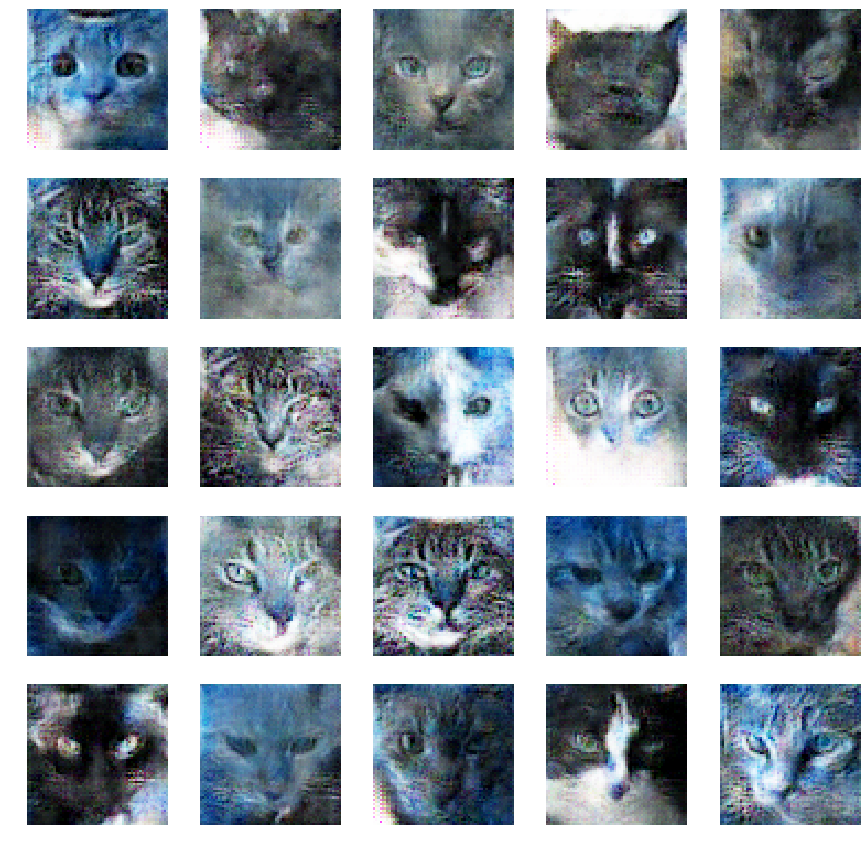

KeyboardInterrupt: 

In [50]:
from keras.models import load_model

epochs = 90000
batch_size = 256
d_loss = [0,0]
g_loss = 0
mean_d_loss=[0,0]
mean_g_loss=0

def train_stuff():
    d_loss = [0,0]
    g_loss = 0
    for i in range(epochs):
        noise= np.random.normal(0,1, [64, 100])
        fake_images = generator.predict(noise)
        fake_output = np.full((64, 1), 0.9)
        indexes = np.random.randint(0, len(os.listdir(path)), 64)
        real_images = images[indexes]
        real_output = np.ones((64,1))
        d_loss = np.add(d_loss, discriminator.train_on_batch(fake_images, fake_output))
        d_loss = np.add(d_loss, discriminator.train_on_batch(real_images, real_output))
        d_loss = d_loss * 0.5
        noise= np.random.normal(0,1, [128, 100])
        #gan.train_on_batch(noise,np.full((128, 1), 1))
        g_loss += gan.train_on_batch(noise,np.full((128, 1), 1))
        if i % 100 == 0:
            print(d_loss)
            print(g_loss)
            d_loss = [0,0]
            g_loss = 0
            save_images(i)
        if i % 1000 == 0:
            discriminator.save('cats_discriminatorV2.h5')  # creates a HDF5 file 'my_model.h5'
            generator.save('cats_generatorV2.h5')

                           
train_stuff()

In [ ]:
discriminator.save('cats_discriminatorV2.h5')  # creates a HDF5 file 'my_model.h5'
generator.save('cats_generatorV2.h5')